In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
paths_to_performances = [
    {
        "hitl_iteration": 1,
        "cv_iteration": 0,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-1' / 'model-selection' / 'validation_performance_cv_iteration_0_MedSAM-ViT-B-20240423-0914.json'
    },
    {
        "hitl_iteration": 1,
        "cv_iteration": 1,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-1' / 'model-selection' / 'validation_performance_cv_iteration_1_MedSAM-ViT-B-20240423-1349.json'
    },
    {
        "hitl_iteration": 1,
        "cv_iteration": 2,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-1' / 'model-selection' / 'validation_performance_cv_iteration_2_MedSAM-ViT-B-20240423-1814.json'
    },
    {
        "hitl_iteration": 1,
        "cv_iteration": 3,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-1' / 'model-selection' / 'validation_performance_cv_iteration_3_MedSAM-ViT-B-20240423-2332.json'
    }
]
paths_to_splits = [
    {
        "hitl_iteration": 1,
        "path": Path.cwd() / 'resources' / 'HITL-iteration-1' / 'model-selection' / 'splits.csv'
    }
]

In [3]:
pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth')

# Obtención de modelos: Validación Cruzada
Se propone una Validación Cruzada de tipo **Leave One Patient Out (LOPO)** para seleccionar el mejor modelo después de cada época de entrenamiento. Se obtiene un modelo para fold de la Validación Cruzada. Todos los modelos obtenidos pasan a ser evaluados sobre el conjunto de test. 

## Iteración 1

- Se tiene un conjunto de entrenamiento con **13 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 1: cáncer gástrico (1 estudio, 2 series anotadas)
    - 2: cáncer gástrico (4 estudios, 6 series anotadas)
    - 3: cáncer de mama (2 estudios, 3 series anotadas)
    - 14: cáncer de pulmón (1 estudio, 2 series anotadas)

In [4]:
# Read splits csv
path_to_splits_it1 = [item["path"] for item in paths_to_splits if item['hitl_iteration'] == 1][0]
splits_it1_df = pd.read_csv(path_to_splits_it1)
display(splits_it1_df)

,filename,series_uuid,slice_idx,patient_code,cv_iteration,subset
0,240_1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719.npy,1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719,240,3,0,train
1,142_1.3.12.2.1107.5.1.4.83504.30000019103012204275800008668.npy,1.3.12.2.1107.5.1.4.83504.30000019103012204275800008668,142,3,0,train
2,92_1.3.12.2.1107.5.1.4.83504.30000019070312170000200010324.npy,1.3.12.2.1107.5.1.4.83504.30000019070312170000200010324,92,3,0,train
3,150_1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719.npy,1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719,150,3,0,train
4,126_1.3.12.2.1107.5.1.4.83885.30000022082507483231400011687.npy,1.3.12.2.1107.5.1.4.83885.30000022082507483231400011687,126,2,0,train
...,...,...,...,...,...,...
3895,253_1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719.npy,1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719,253,3,3,validation
3896,195_1.3.12.2.1107.5.1.4.83504.30000019070312170000200010324.npy,1.3.12.2.1107.5.1.4.83504.30000019070312170000200010324,195,3,3,validation
3897,274_1.3.12.2.1107.5.1.4.83885.30000022082507483231400010975.npy,1.3.12.2.1107.5.1.4.83885.30000022082507483231400010975,274,2,3,train
3898,118_1.3.12.2.1107.5.1.4.83885.30000022082507483231400011687.npy,1.3.12.2.1107.5.1.4.83885.30000022082507483231400011687,118,2,3,train


In [5]:
# Annotated slices for each series and patient
grouped = splits_it1_df.groupby(['patient_code', 'series_uuid']).size()
grouped = grouped.reset_index(name='annotated_slices')
display(grouped)

,patient_code,series_uuid,annotated_slices
0,1,1.3.12.2.1107.5.1.4.83504.30000022071212080050700029044,24
1,1,1.3.12.2.1107.5.1.4.83504.30000022071212080050700029635,44
2,2,1.3.12.2.1107.5.1.4.83504.30000022101213201190600003679,108
3,2,1.3.12.2.1107.5.1.4.83504.30000022112912564272900008711,40
4,2,1.3.12.2.1107.5.1.4.83504.30000022112912564272900009091,116
5,2,1.3.12.2.1107.5.1.4.83504.30000023011707404892200015805,104
6,2,1.3.12.2.1107.5.1.4.83885.30000022082507483231400010975,204
7,2,1.3.12.2.1107.5.1.4.83885.30000022082507483231400011687,200
8,3,1.3.12.2.1107.5.1.4.83504.30000019041511214045100000719,1016
9,3,1.3.12.2.1107.5.1.4.83504.30000019070312170000200010324,1000


In [6]:
# Annotated slices per patient
grouped = splits_it1_df.groupby(['patient_code'])['series_uuid'].size()
grouped = grouped.reset_index(name='annotated_slices')
display(grouped)

,patient_code,annotated_slices
0,1,68
1,2,772
2,3,2896
3,14,164


In [7]:
# Annotated series per patient
grouped = splits_it1_df.groupby('patient_code')['series_uuid'].nunique()
grouped = grouped.reset_index(name='annotated_series')
display(grouped)

,patient_code,annotated_series
0,1,2
1,2,6
2,3,3
3,14,2


In [8]:
# Annotated series for each cv iteration and subset
grouped = splits_it1_df.groupby(['cv_iteration', 'subset'])['series_uuid'].nunique()
grouped = grouped.reset_index(name='annotated_series')
display(grouped)

,cv_iteration,subset,annotated_series
0,0,train,11
1,0,validation,2
2,1,train,11
3,1,validation,2
4,2,train,7
5,2,validation,6
6,3,train,10
7,3,validation,3


In [9]:
# Annotated series per patient, for each cv iteration and subset
grouped = splits_it1_df.groupby(['cv_iteration', 'subset', 'patient_code'])['series_uuid'].nunique()
grouped = grouped.reset_index(name='annotated_series')
display(grouped)

,cv_iteration,subset,patient_code,annotated_series
0,0,train,2,6
1,0,train,3,3
2,0,train,14,2
3,0,validation,1,2
4,1,train,1,2
5,1,train,2,6
6,1,train,3,3
7,1,validation,14,2
8,2,train,1,2
9,2,train,3,3


In [10]:
# Read validation performances
it1_items = [item for item in paths_to_performances if item["hitl_iteration"] == 1]
val_performances_it1 = pd.DataFrame()
for item in it1_items:
    with open(item['path'], 'r') as file:
        df = pd.DataFrame(json.load(file))
    df['cv_iteration'] = item['cv_iteration']
    val_performances_it1 = pd.concat([val_performances_it1, df])
display(val_performances_it1)

,epoch,batch_idx,loss,mean_dice_score,cv_iteration
0,0,0,0.297942,0.616352,0
1,0,1,0.100637,0.854733,0
2,0,2,0.092060,0.872912,0
3,0,3,0.217901,0.740214,0
4,0,4,0.089139,0.880628,0
...,...,...,...,...,...
36195,49,719,0.349123,0.606289,3
36196,49,720,0.208417,0.759582,3
36197,49,721,0.264289,0.699115,3
36198,49,722,0.100301,0.871632,3


In [11]:
# Plot mean dice score for each epoch and cv iteration
mean_std_df = val_performances_it1.groupby(['cv_iteration', 'epoch'])['mean_dice_score'].agg(['mean', 'std']).reset_index()
display(mean_std_df)

,cv_iteration,epoch,mean,std
0,0,0,0.805639,0.120150
1,0,1,0.833705,0.110660
2,0,2,0.844460,0.096115
3,0,3,0.795253,0.138815
4,0,4,0.824020,0.119947
...,...,...,...,...
195,3,45,0.798307,0.123556
196,3,46,0.791458,0.125749
197,3,47,0.805878,0.110713
198,3,48,0.782706,0.150840


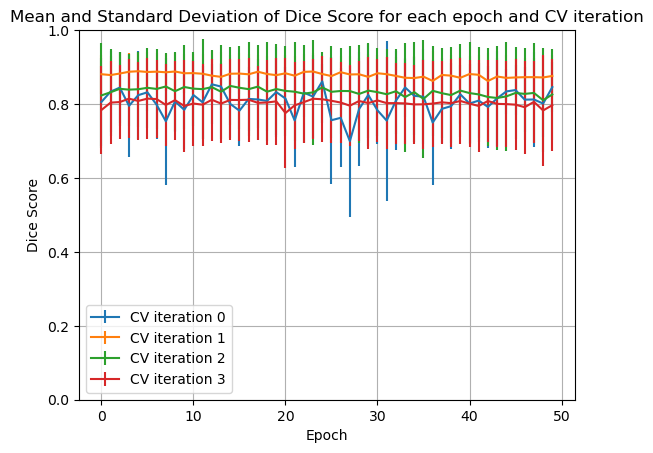

In [19]:
# Mean and std
for cv_iter in mean_std_df['cv_iteration'].unique():
    cv_iter_df = mean_std_df[mean_std_df['cv_iteration'] == cv_iter]
    plt.errorbar(cv_iter_df['epoch'], cv_iter_df['mean'], yerr=cv_iter_df['std'], label=f'CV iteration {cv_iter}')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Mean and Standard Deviation of Dice Score for each epoch and CV iteration')
plt.legend()
plt.ylim((0, 1.0))
plt.grid(True)
plt.show()

#for cv_iter in mean_std_df['cv_iteration'].unique():
#    cv_iter_df = mean_std_df[mean_std_df['cv_iteration'] == cv_iter]
#    plt.errorbar(cv_iter_df['epoch'], cv_iter_df['mean'], yerr=cv_iter_df['std'], label=f'CV iteration {cv_iter}')
#    plt.xlabel('Epoch')
#    plt.ylabel('Dice Score')
#    plt.title('Mean and Standard Deviation of Dice Score for each epoch and CV iteration')
#    plt.ylim((0, 1.0))
#    plt.legend()
#    plt.grid(True)
#    plt.show()

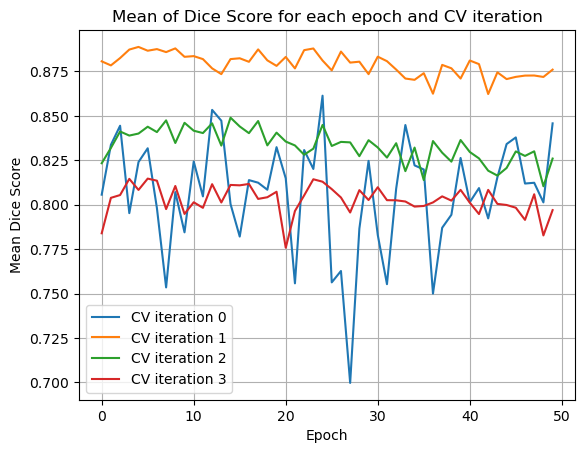

In [15]:
# Mean
for cv_iter in mean_std_df['cv_iteration'].unique():
    cv_iter_df = mean_std_df[mean_std_df['cv_iteration'] == cv_iter]
    plt.plot(cv_iter_df['epoch'], cv_iter_df['mean'], label=f'CV iteration {cv_iter}')

plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Mean of Dice Score for each epoch and CV iteration')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
display(mean_std_df.loc[mean_std_df.groupby('cv_iteration')['mean'].idxmax()])

,cv_iteration,epoch,mean,std
24,0,24,0.861378,0.048191
54,1,4,0.888836,0.053133
114,2,14,0.848997,0.106195
155,3,5,0.814692,0.108960
